# 2DSI Map Creator
In the following part of this notebook a 2DSI map will be created computationally from a Cr:ZnS laser pulse.
Generally, the computation will be done in the frequency domain rather than in the wavelength domain of the electromagnetic fields.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import sys

#!{sys.executable} -m pip install scipy      #useful command if scipy has not been installed yet
from scipy.interpolate import interp1d       #interpolation 

## Cr:ZnS laser pulse's shape and phase:
The Cr:ZnS laser pulse will be centered at $2.3~\mu m$ and Gaussian-shaped with a spectral width corresponding to a bandwidth limited pulse with a temporal FWHM of $35~fs$. The wavelength/frequency axis is defined by the used spectrometers' specifications which has a range from $1.8~\mu m$ (equivalent to: $166~\text{THz}$) to $2.7~\mu m$ (equivalent to: $111~\text{THz}$) and outputs an array of 900 values inbewteen this range.

In [2]:
f_center = 130.6 * 10**12                                            #Center frequeny at 2.3 micrometer (130.6 THz)
f = np.linspace(111 * 10**12,166 * 10**12,900)                       #Cr:ZnS laser pulse frequency axis

#Pulse's shape
t_FWHM = 35                                                          #Bandwidth limited intensity FWHM in femtoseconds
tau_in = (t_FWHM * 10**-15) / np.sqrt(np.log(2))                     #t_FWHM with the additional factor which is necessary for Gaussian shaped pulses
e_f = np.exp(-tau_in**2 / 8 * (4 * np.pi**2) * (f - f_center)**2)    #E-field envelope of the pulse in the frequency domain
i_f = e_f**2                                                         #Intensity envelope of the pulse

The pulses spectral phase was used to be corresponding to the function Ge_phase(thickness). 
This function calculates the spectral phase upon dispersion through Germanium with a certain thickness $d$.

The refractive index data was taken from this database (<a href="https://refractiveindex.info/?shelf=main&book=Ge&page=Burnett">Link</a>)

In [3]:
def Ge_phase(d):
    #d...thickness CaF2 in m
    
    c = 2.99792458 * 10**14                                       #Speed of light (unit: um per s)
    lamb = np.linspace(1.5, 3, 10000)                             #wavelenghts (unit: um)                               
    
    #Sellmeier equation for Germanium:
    nsq = 1 + (0.4886331 * lamb**2) / (lamb**2 - 1.393959) + \
        (14.5142535 * lamb**2) / (lamb**2 - 0.1626427) + \
        (0.0091224 * lamb**2) / (lamb**2 - 752.19)

    n = np.sqrt(np.abs(nsq))                                      #Refractive index
    
    omega = 2*np.pi * c / lamb                                    #Frequency axis (unit: rad/s)                                
    beta = omega * n / (c * 10**-6)                               #Beta (unit: rad/m)
    
    return omega / (2*np.pi), beta * d                            #Return of frequency axis (unit: Hz) and the phase


We will add a phase corresponding to a thickness d of Germanium to the pulse.
Furthermore, the 0th and 1st order of the spectral phase are quantities that can't be measured with 2DSI. Therefore they are eliminated by a polynomial fit centered at the center frequency.

In [4]:
(f_phase, phase) = Ge_phase(0.0005)                          #the frequency axis (unit: Hz) and phase (unit: rad)

#Elimination of 0th and 1st order
poly_coefficient = np.polyfit(f_phase - f_center, phase, 5) #The f_phase-f_center makes the fit centered at f_center.
poly_coefficient[-1] = 0                                    #0th order
poly_coefficient[-2] = 0                                    #1st order

phase_center = np.poly1d(poly_coefficient)(f - f_center)    #The phase centered and evaluated for the frequency axis of the Cr:ZnS laser pulse

### Plot of the Cr:ZnS laser pulse:

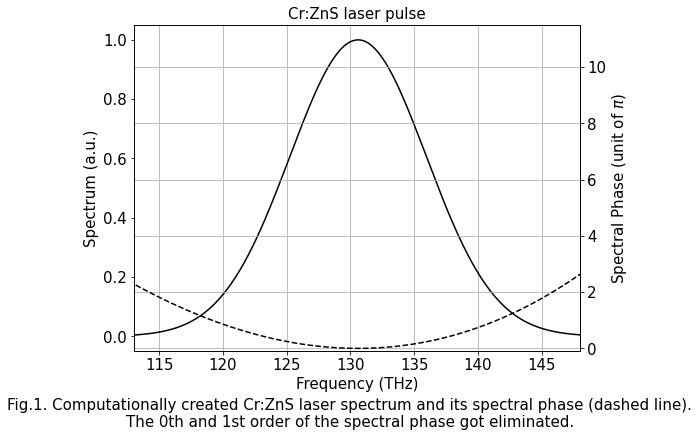

In [5]:
figPulse_f = plt.figure(figsize = (8, 6))
ax_spec = figPulse_f.add_subplot(111)
#Intensity over frequency
ax_spec.plot(f / 10**12, i_f, 'k')                                           #Plot spectrum

#Spectral phase over frequency
ax_phase = ax_spec.twinx()
ax_phase.plot(f / 10**12, phase_center / np.pi, 'k--')                       #Plot phase

#Title and labels
ax_spec.set_title("Cr:ZnS laser pulse", fontsize = 15)
ax_spec.set_xlabel("Frequency (THz)", fontsize = 15)
ax_spec.set_ylabel("Spectrum (a.u.)", fontsize = 15)
ax_phase.set_ylabel("Spectral Phase (unit of $\pi$)", fontsize = 15)
ax_spec.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax_phase.tick_params(axis = 'both', which = 'major', labelsize = 15)

#Figure Caption
figurecounter = 1                                                            #Counter for the figure number
figurecaption = ('Fig.' + str(figurecounter) + '. ' \
                 'Computationally created Cr:ZnS laser spectrum and its spectral phase (dashed line).\n' + \
                 'The 0th and 1st order of the spectral phase got eliminated.')

figPulse_f.text(.5, -0.05, figurecaption, ha = 'center', fontsize = 15)


#Grids
ax_phase.grid()                                                        #The grid of the phase-value ticks is wanted
ax_spec.grid(axis = "x")                                               #But only the frequency gridlines from the x-axis ticks

#Limits
ax_spec.set_xlim((113, 113 + 35))
ax_phase.set_ylim((-0.1, 11.5))
plt.show()

## Spectrally sheared pulses:
In reality the Cr:ZnS laser pulse gets up-converted via sum-frequency generation (SFG) with two different quasi-CW frequency components. Here, the spectrally sheared pulses are created by defining the center frequency of the Cr:ZnS laser pulse as one quasi-CW component and the other by the quasi-CW component plus the shear frequency $\Omega$.
A perfect 1:1 non-linear optical up-conversion was assumed.

In [6]:
f_shear = 1 * 10**12                                #Shear frequency (unit: Hz)
#Determination of the SFG-axis for the interpolation of them to the frequency axis f_2DSI.
f_sfg1 = f + f_center                               #SFG axis pulse1 (unit: Hz)
f_sfg2 = f_sfg1 + f_shear                           #SFG axis pulse2 (unit: Hz)

max_f = int((f_sfg1[-1] - f_sfg2[0]) / 10**12 - 1)  #calculation of the new frequency for f_2DSI.

f_2DSI = (np.arange(0, max_f, 0.1) + round(f_sfg2[0] / 10**12)) * 10**12         #2DSI map frequency axis (unit: Hz)

In [7]:
#Interpolation onto the same frequency axis: f_2DSI
#SFG pulse1
interpol_spectrum1 = interp1d(f_sfg1, i_f, kind='cubic')             #interpolation of the sfg pulse1 spectrum
spec_SFG1 = interpol_spectrum1(f_2DSI)                               #spectrum interpolated onto new axis
interpol_spectrum1 = interp1d(f_sfg1, phase_center, kind='cubic')    #interpolation of the sfg pulse1 phase
phase_SFG1 = interpol_spectrum1(f_2DSI)                              #phase interpolated onto new axis

#SFG pulse2
interpol_spectrum2 = interp1d(f_sfg2, i_f, kind='cubic')             #interpolation of the sfg pulse2 spectrum
spec_SFG2 = interpol_spectrum2(f_2DSI)                               #spectrum interpolated onto new axis
interpol_spectrum2 = interp1d(f_sfg2, phase_center, kind='cubic')    #interpolation of the sfg pulse2 phase
phase_SFG2 = interpol_spectrum2(f_2DSI)                              #phase interpolated onto new axis

### Plot of the spectrally sheared pulses:

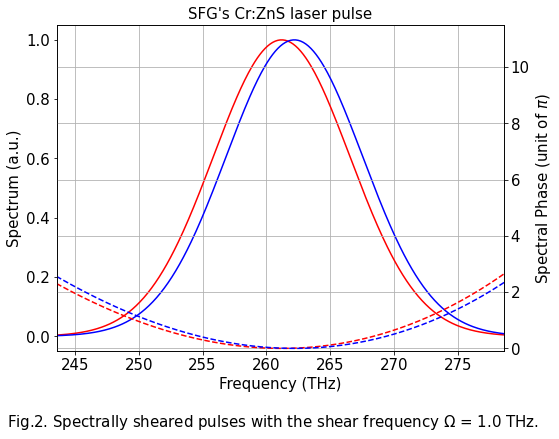

In [8]:
figPulse_f = plt.figure(figsize = (8, 6))
ax_spec = figPulse_f.add_subplot(111)
#Spectra
ax_spec.plot(f_2DSI / 10**12, spec_SFG1, 'r')                                #sfg pulse1 spectrum
ax_spec.plot(f_2DSI / 10**12, spec_SFG2, 'b')                                #sfg pulse2 spectrum

#Phase
ax_phase = ax_spec.twinx()
ax_phase.plot(f_2DSI / 10**12, phase_SFG1 / np.pi,'r--')                     #sfg pulse1 phase
ax_phase.plot(f_2DSI / 10**12, phase_SFG2 / np.pi,'b--')                     #sfg pulse2 phase

#Title and labels
ax_spec.set_title("SFG's Cr:ZnS laser pulse", fontsize = 15)
ax_spec.set_xlabel("Frequency (THz)", fontsize = 15)
ax_spec.set_ylabel("Spectrum (a.u.)", fontsize = 15)
ax_phase.set_ylabel("Spectral Phase (unit of $\pi$)", fontsize = 15)
ax_spec.tick_params(axis = 'both', which='major', labelsize = 15)
ax_phase.tick_params(axis = 'both', which='major', labelsize = 15)

#Figure Caption
figurecounter = 2                                                             #Counter for the figure number
figurecaption = ('Fig.' + str(figurecounter) + '. ' \
                 'Spectrally sheared pulses with the shear frequency $\Omega$ = ' + \
                 str(f_shear/10**12) + ' THz.')

figPulse_f.text(.5, -0.05, figurecaption, ha='center', fontsize = 15)


#Grids
ax_phase.grid()
ax_spec.grid(axis = "x")

#Limits
ax_spec.set_xlim((113 + f_center / 10**12, 113 + 35 + f_center / 10**12))
ax_phase.set_ylim((-0.1, 11.5))
plt.show()

## 2DSI map:
Now everything is done to finally compute the 2DSI map which behaves according to:

$$S_{2DSI}(\omega, \tau_{CW}) = S(\omega) + S(\omega-\Omega) + \sqrt{S(\omega) S(\omega-\Omega)} cos(\Phi_0 + \Phi(\omega)- \Phi(\omega - \Omega))$$

Here the 2DSI-Signal: $S_{2DSI}(\omega, \tau_{CW})$ is soley computed by the spectra of the sheared pulses $S(\omega)$ and $S(\omega-\Omega)$ and its spectral phases $\Phi(\omega)$ and $\Phi(\omega - \Omega)$. $\Phi_0$ is the absolute phase shift that is modulated by the stage-$\tau_{CW}$.

In [9]:
num_periods = 5                                          #number of periods visible in the 2DSI map
num_rad = num_periods * 2 * np.pi                        #number of radians

phi_0_res = 11                                           #resolution of the phase shift (unit: spectra per period)
num_spectra = phi_0_res * num_periods


map_2DSI = np.empty((num_spectra, np.size(f_2DSI)))      #empty 2DSI map

phi_0_array = np.linspace(0, 1, num_spectra) * num_rad   #absolute phase array Phi_0 (unit rad)
phi_0_array = phi_0_array + 0.5*np.pi

### Filling the 2DSI map:
The function fill2DSImap(abs_phase) returns the value for $S_{2DSI}(\omega, \tau_{CW})$ for each absolute phase value $\Phi_0$.
The variation of $\Phi_0$ results in the fringes of the spectral signal (or, the modulation of the spectral signal) due to the cosine.

In [10]:
def fill2DSImap(abs_phase):
    #abs_phase...absolute phase phi0 according to the S_2DSI behaviour (unit rad)
    phase_arg = abs_phase + phase_SFG1 - phase_SFG2                                     #argument of the cosine in the 2DSI equation
    
    return np.sqrt(spec_SFG1 * spec_SFG2) * np.cos(phase_arg) + spec_SFG1 + spec_SFG2   #2DSI signal equation

#Filling of the 2DSI map:
for i, phi_0 in enumerate(phi_0_array):
    map_2DSI[i, :] = fill2DSImap(phi_0)                                                 #iteration through all phi_0_array values.

### Plot 2DSI map:

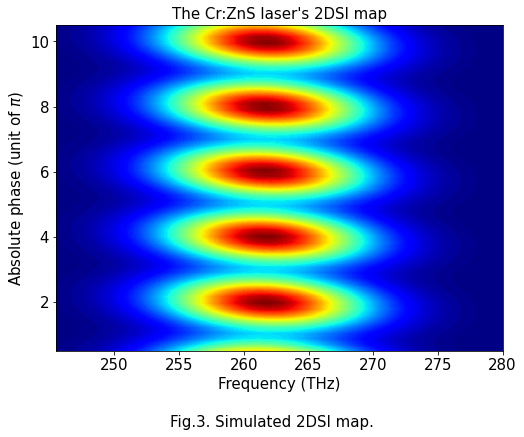

In [11]:
(f_2DSI_2D, phi_0_array_2D) = np.meshgrid(f_2DSI, phi_0_array)                  #Creation of the 2D array fields for the countour plot

figMap2DSI = plt.figure(figsize = (8, 6))
ax0 = figMap2DSI.add_subplot(111)
ax0.contourf(f_2DSI_2D / 10**12, phi_0_array_2D / np.pi, map_2DSI, 100, cmap = 'jet') #contour plot of the 2DSI map

#Title and labels
ax0.set_title("The Cr:ZnS laser's 2DSI map", fontsize = 15)
ax0.set_ylabel(r"Absolute phase (unit of $\pi$)", fontsize = 15)
ax0.set_xlabel("Frequency (THz)", fontsize = 15)
ax0.tick_params(axis = 'both', which='major', labelsize = 15)
ax0.tick_params(which = 'major', axis = 'x', direction = 'out')                   #x-axis ticks outside of contour plot region
ax0.tick_params(which = 'major', axis = 'y', direction = 'out')                   #y-axis ticks outside of contour plot region

#Figure Caption
figurecounter = 3                                                             #Counter for the figure number
figurecaption = ('Fig.' + str(figurecounter) + '. ' \
                 'Simulated 2DSI map.')

figMap2DSI.text(.5, -0.05, figurecaption, ha = 'center', fontsize = 15)         #Figure caption



#Limits
ax0.set_xlim((245.5, 280))
plt.show()

## Creating a pandas data frame:

In [12]:
#Dataframe for the pulse:
data_pulse = {'f (Hz)': f, 'spec (norm.)': i_f, 'phase (rad)': phase_center, 'shear (Hz)': f_shear}        #creation of a dictonary
df_pulse = pd.DataFrame(data = data_pulse)
df_pulse.description = 'Center frequency = ' + str(f_center / 10**12) + ' THz'      #Center frequency in THz as description

#Dataframe for the 2DSI map:
df_2DSImap = pd.DataFrame(data = map_2DSI, columns = f_2DSI, index = phi_0_array)

#Save to csv-file in the Data folder
df_pulse.to_csv('Data/Pulse.csv')
df_2DSImap.to_csv('Data/2DSImap.csv')